# Traveling Sales Person

In [1]:
import random
from typing import List
import logging
import numpy as np
from enum import Enum
from tqdm import tqdm
import matplotlib.pyplot as plt


class VariationOperator(Enum):
    MUTATION_SCRAMBLE = 1
    MUTATION_INVERSION = 1
    PMX = 2


class MutationType(Enum):
    INVERSION = 1
    SCRAMBLE = 2


log_level = logging.INFO
logging.basicConfig(level=log_level, format="%(asctime)s - %(levelname)s - %(message)s")
logging.getLogger(__name__).setLevel(log_level)


class TSP:
    def __init__(self, dists_matrix, n_population: int):
        self.__best_costs: List[int] = []
        self.__worst_costs: List[int] = []
        self.__best_routes = []
        self.__worst_routes = []
        self.__dists_matrix = dists_matrix
        assert len(dists_matrix) == len(dists_matrix[0])
        self.__n_cities = len(dists_matrix)

        self.__population = np.zeros((n_population, self.__n_cities), dtype=np.int16)
        for i in tqdm(range(n_population), desc="Initializing Population"):
            self.__population[i] = self.__get_random_sample()

    def __get_random_sample(self):
        # subtle tof, don't choose repetitive
        s = np.arange(self.__n_cities)
        np.random.shuffle(s)
        return s

    def __cost(self, s):
        cost = 0
        for i in range(len(s)):
            a, b = s[i], s[i - 1]
            cost += self.__dist(a, b)

        return cost

    def __dist(self, a, b):
        return self.__dists_matrix[a, b]

    def __mutate(self, s, typ: MutationType):
        x, y = random.sample(range(self.__n_cities), 2)
        first, last = min(x, y), max(x, y)
        subset = np.copy(s[first:last])
        if typ == MutationType.INVERSION:
            return list(s[:first]) + list(subset[::-1]) + list(s[last:])
        elif typ == MutationType.SCRAMBLE:
            np.random.shuffle(subset)
            return list(s[:first]) + list(subset) + list(s[last:])
        else:
            raise ValueError(f"invalid mutation type {typ}")

    def __pmx(self, s1, s2):
        length = len(parent1)
        child1, child2 = parent1.copy(), parent2.copy()
    
        # Choose crossover points
        crossover_point1 = random.randint(0, length - 2)
        crossover_point2 = random.randint(crossover_point1 + 1, length - 1)
    
        # Create mappings
        mapping1 = {}
        mapping2 = {}
    
        for i in range(crossover_point1, crossover_point2 + 1):
            element1, element2 = parent1[i], parent2[i]
            child1[i], child2[i] = element2, element1
            mapping1[element1] = element2
            mapping2[element2] = element1
    
        # Apply mapping to the rest of the elements
        for i in range(length):
            if not crossover_point1 <= i <= crossover_point2:
                while child1[i] in mapping1:
                    child1[i] = mapping1[child1[i]]
                while child2[i] in mapping2:
                    child2[i] = mapping2[child2[i]]

        # return one child at random
        if random.Choice([True, False]):
            return child1
        return child2

    def iterate(self, n_iters: int, var_op: VariationOperator):
        for _ in tqdm(range(n_iters), desc="Iterating"):
            if var_op == VariationOperator.MUTATION_INVERSION:
                self.__population = self.__mutate_population(
                    self.__population,
                    MutationType.INVERSION,
                    len(self.__population),
                )
            if var_op == VariationOperator.MUTATION_SCRAMBLE:
                self.__population = self.__mutate_population(
                    self.__population,
                    MutationType.SCRAMBLE,
                    len(self.__population),
                )
            elif var_op == VariationOperator.PMX:
                self.__population = self.__crossover_population(
                    self.__population, len(self.__population)
                )
            else:
                raise ValueError(f"invalid variation operator {var_op}")

            best_route, best_cost = self.__find_best(self.__cost)
            worst_route, worst_cost = self.__find_worst(self.__cost)
            
            self.__best_costs.append(best_cost)
            self.__best_routes.append(best_route)
            self.__worst_costs.append(worst_cost)
            self.__worst_routes.append(worst_route)

    def get_best_route(self):
        best_route = self.__best_routes[-1]
        guide = f"{best_route[0]}"
        for i in range(1, len(best_route)):
            guide += f" --> {best_route[i]}"
        return best_route, guide

    def get_best_routes(self):
        return self.__best_routes

    def get_worst_route(self):
        worst_route = self.__worst_routes[-1]
        guide = f"{worst_route[0]}"
        for i in range(1, len(worst_route)):
            guide += f" --> {worst_route[i]}"
        return worst_route, guide

    def get_worst_routes(self):
        return self.__worst_routes

    def __mutate_population(self, init_pop, typ: MutationType, final_pop_size: int):
        new_pop = [self.__mutate(p, typ=typ) for p in init_pop]
        new_pop.extend(init_pop)
        return self.__select(new_pop, final_pop_size)

    def __crossover_population(self, init_pop, final_pop_size: int):
        new_pop = init_pop.copy()
        for _ in range(len(init_pop)):
            couple = random.sample(init_pop, 2)
            new_pop.append(self.__pmx(couple[0], couple[1]))

        return self.__select(new_pop, final_pop_size)

    def __find_best(self, cost_fn):
        best_cost = cost_fn(self.__population[0])
        best = self.__population[0]
        for p in self.__population:
            cost = cost_fn(p)
            if cost < best_cost:
                best_cost = cost
                best = p

        return best, best_cost

    def __find_worst(self, cost_fn):
        worst_cost = cost_fn(self.__population[0])
        worst = self.__population[0]
        for p in self.__population:
            cost = cost_fn(p)
            if cost > worst_cost:
                worst_cost = cost
                worst = p

        return worst, worst_cost

    def __select(self, pop, pop_size: int):
        assert len(pop) >= pop_size

        fs = [(i, self.__cost(p)) for i, p in enumerate(pop)]
        fs = sorted(fs, key=lambda x: x[1])
        selected = []
        for i in range(pop_size):
            idx, _ = fs[i]
            selected.append(pop[idx])

        return selected

    def plot_costs(self):
        plt.plot(range(1, len(self.__best_costs) + 1), self.__best_costs, label="Best")
        plt.plot(
            range(1, len(self.__worst_costs) + 1), self.__worst_costs, label="Worst"
        )
        plt.xlabel("# Iteration")
        plt.ylabel("Score")
        plt.axhline(
            y=self.__best_costs[-1],
            color="green",
            linestyle="--",
            label=f"Final Best: {self.__best_costs[-1]}",
        )
        plt.axhline(
            y=self.__worst_costs[-1],
            color="red",
            linestyle="--",
            label=f"Final Worst: {self.__worst_costs[-1]}",
        )
        plt.axhline(
            y=self.__best_costs[0],
            color="green",
            linestyle="dotted",
            label=f"First Best: {self.__best_costs[0]}",
        )
        plt.axhline(
            y=self.__worst_costs[0],
            color="red",
            linestyle="dotted",
            label=f"First Worst: {self.__worst_costs[0]}",
        )
        plt.legend()
        plt.show()

    def plot_route(self):
        pass


In [2]:
with open("cities.txt") as f:
    lines = f.readlines()

dists_matrix = np.zeros((30, 30))

for i in range(2, 32):
    line = lines[i]
    line = line.replace("\n", "")
    dists = line.split("\t")
    dists_matrix[i - 2] = dists

print(dists_matrix.shape)
dists_matrix[:5, :5]

(30, 30)


array([[99999.,  1590.,  2002.,  2296.,  1453.],
       [ 1590., 99999.,   577.,   936.,   595.],
       [ 2002.,   577., 99999.,   358.,   607.],
       [ 2296.,   936.,   358., 99999.,   848.],
       [ 1453.,   595.,   607.,   848., 99999.]])

Iterating: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 316.23it/s]


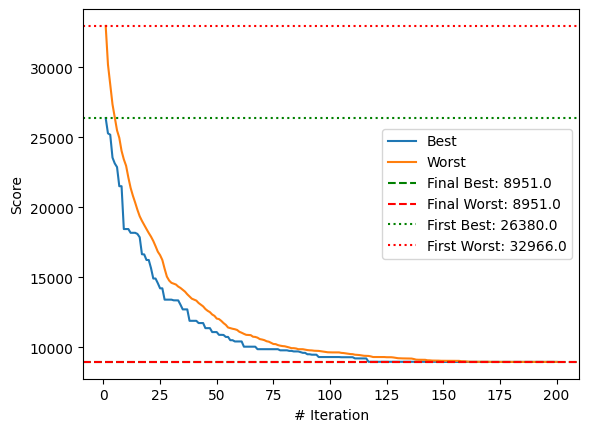

In [3]:
tsp = TSP(dists_matrix, n_population=100)
tsp.iterate(200, VariationOperator.MUTATION_SCRAMBLE)
tsp.plot_costs()

In [4]:
best_nodes, best_guide = tsp.get_best_route()
best_guide

'3 --> 18 --> 17 --> 20 --> 2 --> 29 --> 21 --> 7 --> 6 --> 1 --> 10 --> 26 --> 11 --> 27 --> 0 --> 22 --> 13 --> 14 --> 19 --> 23 --> 24 --> 8 --> 12 --> 25 --> 16 --> 15 --> 4 --> 5 --> 9 --> 28'

In [5]:
worst_nodes, worst_guide = tsp.get_worst_route()
worst_guide

'3 --> 18 --> 17 --> 20 --> 2 --> 29 --> 21 --> 7 --> 6 --> 1 --> 10 --> 26 --> 11 --> 27 --> 0 --> 22 --> 13 --> 14 --> 19 --> 23 --> 24 --> 8 --> 12 --> 25 --> 16 --> 15 --> 4 --> 5 --> 9 --> 28'

## Custom Points Dataset

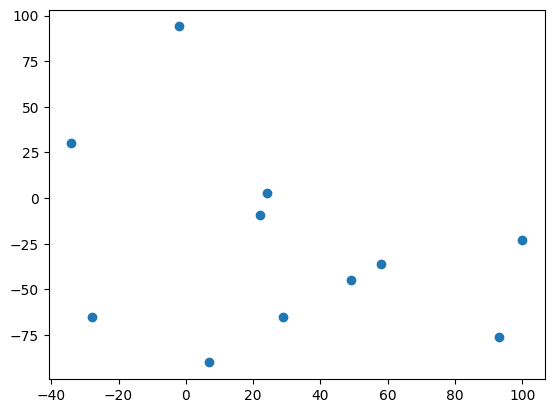

In [149]:
import random 

def gen_points(n_points, x_lower, y_lower, x_upper, y_upper):
    points = np.zeros((n_points, 2), dtype=int)
    for i in range(n_points):
        p = gen_point(x_lower, y_lower, x_upper, y_upper)
        points[i] = p
    
    return points

def gen_point(x_lower, y_lower, x_upper, y_upper):
    x, y = random.randint(x_lower, x_upper), random.randint(y_lower, y_upper)
    return np.array([x, y], dtype=int)

random.seed(0)
n_points = 11
points = gen_points(n_points, -100, -100, 100, 100)
plt.scatter(points[:, 0], points[:, 1])
plt.show()

In [150]:
def calculate_dists(points):
    dists_matrix = np.zeros((len(points), len(points)), dtype=float)
    for i in range(len(points)):
        for j in range(len(points)):
            if i == j:
                dists_matrix[i, j] = float("inf")
                continue

            dists_matrix[i, j] = calculate_dist(points[i], points[j])
            
    return dists_matrix

def calculate_dist(x, y):
    "returns euclidean distance"
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2) ** 0.5


dists_matrix = calculate_dists(points)
dists_matrix[:5, :5]

array([[         inf, 184.2199772 ,  71.55417528,  94.64142856,
        155.21919984],
       [184.2199772 ,          inf, 126.81088281,  94.5409964 ,
        114.62111498],
       [ 71.55417528, 126.81088281,          inf,  63.97655821,
        144.10065926],
       [ 94.64142856,  94.5409964 ,  63.97655821,          inf,
         80.32434251],
       [155.21919984, 114.62111498, 144.10065926,  80.32434251,
                 inf]])

## search all space

In [151]:
best = {
    "cost": float("inf"),
    "sol": [],
}

def calculate_cost(sol):
    cost = 0
    for i in range(len(sol)):
        a, b = sol[i], sol[i - 1]
        cost += dists_matrix[a, b]

    return cost

def get_next_point(sol, n_points, sol_contains, best):
    if len(sol) == n_points:
        cost = calculate_cost(sol)
        if cost < best["cost"]:
            best["cost"] = cost
            best["sol"] = sol
        return
    for i in range(n_points):
        if sol_contains.get(i) is None:
            new_sol = sol + [i]
            new_sol_contains = sol_contains.copy()
            new_sol_contains[i] = True
            get_next_point(new_sol, n_points, new_sol_contains, best)

%time get_next_point([], n_points, {}, best)

CPU times: user 1min 34s, sys: 45.8 ms, total: 1min 34s
Wall time: 1min 34s


In [152]:
best

{'cost': 569.9562078924716, 'sol': [0, 3, 5, 6, 10, 4, 9, 7, 1, 8, 2]}

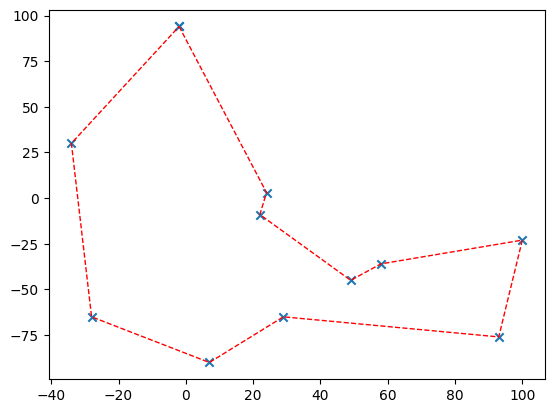

In [153]:
BEST_POINTS = get_route_points(points, best["sol"])
plt.plot(BEST_POINTS[:, 0], BEST_POINTS[:, 1], color="red", linestyle="dashed", linewidth=1)
plt.scatter(BEST_POINTS[:, 0], BEST_POINTS[:, 1], marker="x")

In [154]:
tsp = TSP(dists_matrix, n_population=10)
%time tsp.iterate(100, VariationOperator.MUTATION_INVERSION)

Iterating: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4404.95it/s]

CPU times: user 63.4 ms, sys: 3.02 ms, total: 66.4 ms
Wall time: 24.5 ms


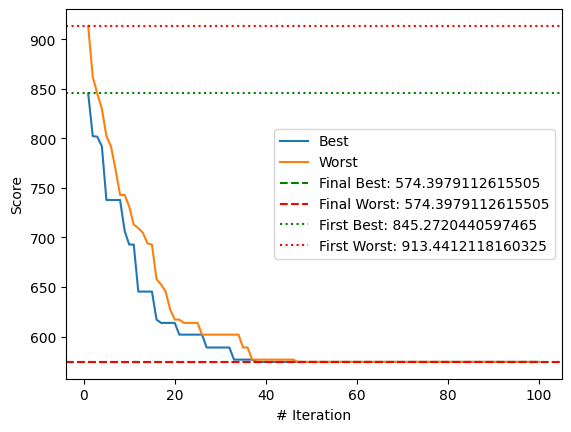

In [155]:
tsp.plot_costs()

In [156]:
def get_route_points(points, route_idx):
    route_points = [points[i] for i in route_idx]
    # add the first node again to close the loop
    route_points.append(points[route_idx[0]])
    route_points = np.array(route_points)
    return route_points

In [157]:
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

def plot_func(iteration):
    route_idx = best_routes[iteration-1]
    route_points = get_route_points(points, route_idx)
    plt.plot(route_points[:, 0], route_points[:, 1], color="red", linestyle="dashed", linewidth=1)
    plt.scatter(route_points[:, 0], route_points[:, 1], marker="x")

best_routes = tsp.get_best_routes()

interact(plot_func, iteration=IntSlider(min=1, max=len(best_routes), step=1))
plt.show()

interactive(children=(IntSlider(value=1, description='iteration', min=1), Output()), _dom_classes=('widget-int…

## Benchmark different variation operators

Iterating: 100%|███████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 207.40it/s]


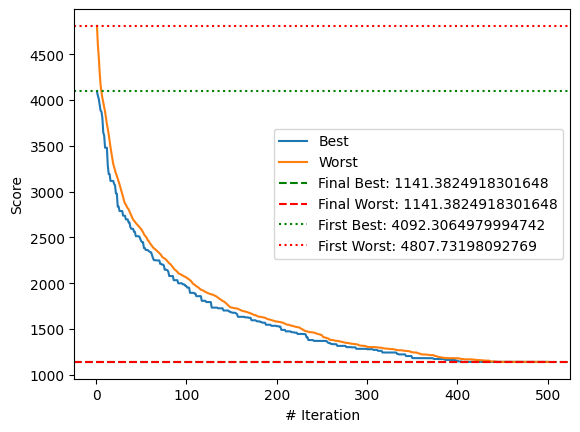

interactive(children=(IntSlider(value=1, description='iteration', max=500, min=1), Output()), _dom_classes=('w…

Iterating: 100%|███████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 211.85it/s]


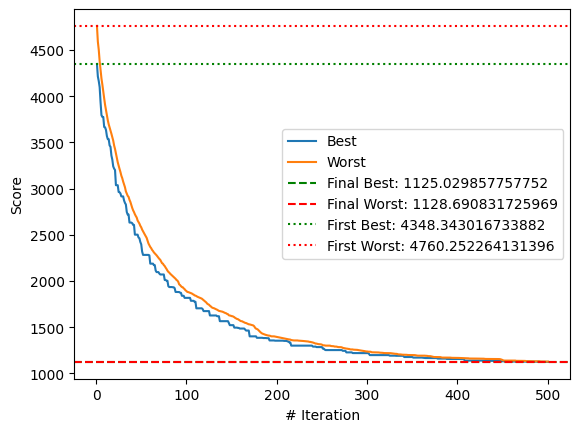

interactive(children=(IntSlider(value=1, description='iteration', max=500, min=1), Output()), _dom_classes=('w…

In [11]:
tsp = TSP(dists_matrix, n_population=100)
tsp.iterate(500, VariationOperator.MUTATION_INVERSION)
tsp.plot_costs()
best_routes = tsp.get_best_routes()

interact(plot_func, iteration=IntSlider(min=1, max=len(best_routes), step=1))
plt.show()

tsp = TSP(dists_matrix, n_population=100)
tsp.iterate(500, VariationOperator.MUTATION_SCRAMBLE)
tsp.plot_costs()
best_routes = tsp.get_best_routes()

interact(plot_func, iteration=IntSlider(min=1, max=len(best_routes), step=1))
plt.show()